# Boosting method and Neural Net in Python

In this project, 200 training examples $X_i\in[0,1]^2$ is used, and $Y_i = X_{i1}^2+X_{i1}^2+\epsilon \sim (0, 0.01)$. The testing examples are generated with a grid of 625 $X_i$'s equally spaced, to approximate the true distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Regression: Matching pursuit

In [2]:
def matching_pursuit(x_train, y_train, lamb, x_test, y_test):
    n, p = x_train.shape
    # init
    x, res = x_train, y_train    
    loss, L = sum(res**2), sum((res-np.mean(res))**2)
    cuts = []
    pnlty, cut = np.float64(0), None   
    # cut
    while loss > L:
        loss = L.copy()
        penalty = pnlty.copy()
        cuts.append(cut)
        # fit the residual
        y = res.copy()      
        for j in range(p):
            for i in range(n-1):
                idx = x[:,j]<=x[i,j]
                c = [np.mean(y[idx]), np.mean(y[idx==0])]
                f = [c[0]*x+c[1]*(1-x) for x in idx]
                new_res = y - f
                new_pnlty = penalty + lamb # (penalty + lamb*sum(c))
                new_L = sum(new_res**2)+new_pnlty
                if new_L < L:
                    res, L, pnlty = new_res.copy(), new_L.copy(), new_pnlty.copy()
                    cut = [c, x[i,j], j]
    del cuts[0]
    train_loss = (loss-penalty)/n
    # test
    nt = len(y_test)
    y_hat = np.zeros((nt))
    for i in range(len(cuts)):
        c, cut, j = cuts[i]
        y_hat += c[0]*(x_test[:,j]<=cut)+c[1]*(x_test[:,j]>cut)
    test_loss = (sum((y_hat-y_test)**2))/nt
    return y_hat, cuts, train_loss, test_loss

In [3]:
### training data
np.random.seed(7)
n = 200
sigma = 0.01
x_train = np.random.uniform(0,1,[n,2])
y_train = np.sum(x_train**2, axis=1)+np.random.normal(0,1,n)*sigma
## testing data
nt = 25
x1, x2 = np.array(range(1,nt+1))/nt, np.array(range(1,nt+1))/nt
x_test = np.array(np.meshgrid(x1, x2)).reshape((2, nt**2)).transpose()
y_test = np.sum(x_test**2, axis=1)+np.random.normal(0,1,nt**2)*sigma

In [4]:
lambs = np.array(range(1,11))/20
train_ls = []
test_ls = []
for l in lambs:
    _, _, train_loss, test_loss = matching_pursuit(x_train, y_train, l, x_test, y_test)
    train_ls.append(train_loss)
    test_ls.append(test_loss)

/Users/alice/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alice/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
### choose model with the smallest testing error
lamb_optimal = lambs[np.argmin(test_ls)]
lamb_optimal

0.05

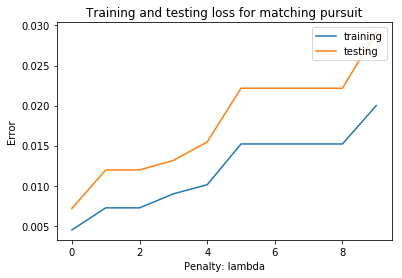

In [6]:
plt.figure()
plt.title('Training and testing loss for matching pursuit')
plt.xlabel('Penalty: lambda')
plt.ylabel('Error')
plt.plot(train_ls, label='training')
plt.plot(test_ls, label='testing')
plt.legend(loc='upper right')
plt.savefig("1-1.png")

In [7]:
y_hat, cuts, train_loss, test_loss = matching_pursuit(x_train, y_train, lamb_optimal, x_test, y_test)    

/Users/alice/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alice/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


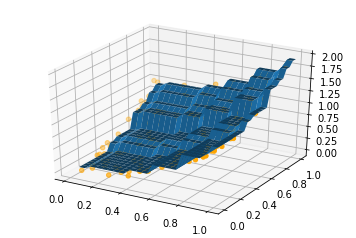

In [8]:
plt.close()
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, label = "train", c='orange')
ax.plot_surface(x1.reshape(1,nt), x2.reshape(nt,1), y_hat.reshape(nt,nt))
plt.savefig("1-2.png")

With regularization on the number of cuts, it can be found that the smaller regularization, the more cuts in the X space. As the noise is very small in our training data, more cuts gives a more precise result. The fitted function below is very close to the truth $f(x)=x_1^2+x_2^2$.

## Classification: Adaboost

In [9]:
def adaboost(x_train, yc_train, x_test, yc_test, num_iteration=200): 
    n, p = x_train.shape
    nt = x_test.shape[0]
    x, y, y_test = x_train, yc_train.reshape(n,1), yc_test.reshape(nt,1) 
    # init
    clfs, err_trains, err_tests = [], [], [] 
    D = np.ones((n,1))/n
    train_score, test_score = np.zeros((n,1)), np.zeros((nt,1))
    # cut
    for it in range(num_iteration): 
        eps = 1
        for j in range(p):
            for i in range(n):
                h = np.ones((n,1))    
                idx = x[:,j]<=x[i,j]
                c = -1
                h[idx] = -1
                mistake = (y!=h)
                if sum(mistake) > n/2:
                    c = 1
                    h = -1*h
                    mistake = (y!=h) 
                eps_new = np.sum(D*mistake)
                if eps_new < eps:
                    eps = eps_new.copy()
                    classifier = (c, x[i,j], j, eps)
                    h_est = h.copy()
        beta = 0.5*np.log((1-eps)/eps)
        score = h_est*beta
        train_score += score
        err_trains.append(np.mean(((train_score>=0)*2-1)!=y))
        # update D
        D = D*np.exp(-y*score)
        D = D/np.sum(D) # n*1
        # test
        c, cut, j, _ = classifier
        h_hat = c*(x_test[:,j]<=cut)-c*(x_test[:,j]>cut)
        score = h_hat.reshape((nt,1))*beta
        test_score += score
        err_tests.append(np.mean(((test_score>=0)*2-1)!=y_test))
        clfs.append(classifier) 
    return test_score, clfs, err_trains, err_tests

In [10]:
yc_train = (y_train-0.8>=0)*2-1
yc_test = (y_test-0.8>=0)*2-1

In [11]:
result, clfs, err_trains, err_tests = adaboost(x_train, yc_train, x_test, yc_test, num_iteration=30)

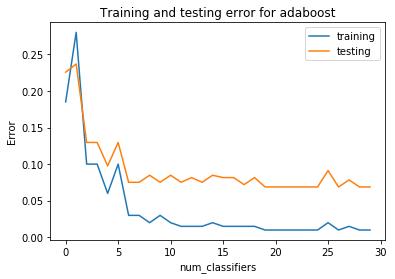

In [12]:
plt.close()
plt.title('Training and testing error for adaboost')
plt.xlabel('num_classifiers')
plt.ylabel('Error')
plt.plot(err_trains, label='training')
plt.plot(err_tests, label='testing')
plt.legend(loc='upper right')
plt.savefig("2-1.png")

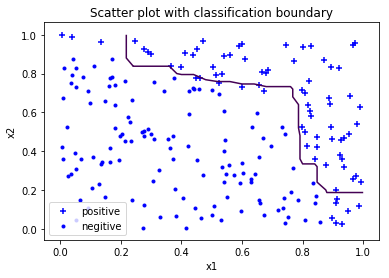

In [13]:
plt.title('Scatter plot with classification boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x_train[yc_train==1,0], x_train[yc_train==1,1], c='b', marker="+", label = 'positive')
plt.scatter(x_train[yc_train==-1,0], x_train[yc_train==-1,1], c='b', marker=".", label = 'negitive')
plt.legend()
plt.contour(x1, x2, result.reshape((nt, nt)), [1])
plt.savefig("2-3.png")

It can be observed that the error rate of adaboost does not change monotonely, while it decrease as more classifier is included in general. A total of 20 weak classifiers gives the classification boundrary below which is quite satifying.

## Neural Network

After tuning the parameter, a learning rate of 0.001 and initialization with 0.01 scale is chosen, by which MSE/error-rate below 0.05 can be achieved within 200 training epoches.

In [14]:
# one hidden layer and ReLU non-linearity
def forward(x, w, b, relu = True):
    s = np.dot(x, w)+b # x: n*p, w: p*d, b: d*1, s:n*d
    h = s.copy() # n*d
    if relu:
        h[s<0] = 0
    cache = (x, w, b, s)
    return h, cache
def backward(dout, cache, relu = True):
    x, w, b, s = cache
    ds = dout.copy() # n*d
    if relu:
        ds[s<0] = 0
    dx = np.dot(ds, w.T) # n*p 
    dw = np.dot(x.T, ds) # p*d
    db = np.sum(ds, axis=0) # d*1
    return dx, dw, db 
def my_NN(x_train, y_train, x_test,y_test, num_hidden=5, learning_rate=1e-5, num_epoch=300, scale=1e-2, clf=False):
    n, p = x_train.shape
    y_train = y_train.reshape(n,1)
    y_test = y_test.reshape(len(y_test),1)
    # init
    w = np.random.standard_normal((p,num_hidden))*scale
    b = np.random.standard_normal((num_hidden))*scale
    beta = np.random.standard_normal((num_hidden,1))*scale # d*1
    err_trains, err_tests = [], []
    for it in range(num_epoch):
        w_cache = w.copy()
        h, cache1 = forward(x_train, w, b, relu=True) # n*d
        score, cache2 = forward(h, beta, 0, relu=False) # regression n*1
        if clf == True:            
            f = ((np.exp(score)-np.exp(-score))/(np.exp(score)+np.exp(-score))>=0)*2-1 # sigmoid
            if min(y_train) == 0:
                f = 1/(1+np.exp(-score))>=0.5 
            err = np.mean(y_train!=f)
        else: 
            f = score
            err = np.mean((y_train-f)**2)
        err_trains.append(err)  
        # testing
        f_hat, _ = forward(forward(x_test, w, b)[0], beta, 0, relu=False)
        if clf == True:
            f_hat = ((np.exp(f_hat)-np.exp(-f_hat))/(np.exp(f_hat)+np.exp(-f_hat))>=0)*2-1 # sigmoid
            if min(y_test) == 0:
                f_hat = 1/(1+np.exp(-f_hat))>=0.5
            err = np.mean(y_test!=f_hat)
        else:
            err = np.mean((y_test-f_hat)**2)    
        err_tests.append(err) 
        # backprop
        dout = y_train-score
        dh, dbeta, _ = backward(dout, cache2, relu=False)
        _, dw, db = backward(dh, cache1)
        beta = beta + learning_rate*dbeta        
        w = w + learning_rate*dw
        b = b + learning_rate*db
    par = (w, b, beta)
    return par, f_hat, err_trains[2:], err_tests

In [15]:
# regression
par, f_hat, err_trains, err_tests = my_NN(x_train, y_train, x_test,y_test, num_hidden=20, \
                                          learning_rate=1e-3, num_epoch=300, scale=1e-2, clf=False)

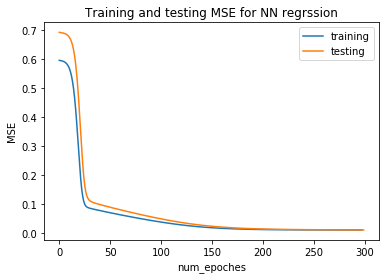

In [16]:
plt.close()
plt.title('Training and testing MSE for NN regrssion')
plt.xlabel('num_epoches')
plt.ylabel('MSE')
plt.plot(err_trains, label='training')
plt.plot(err_tests, label='testing')
plt.legend(loc='upper right')
plt.savefig("3-1.png")

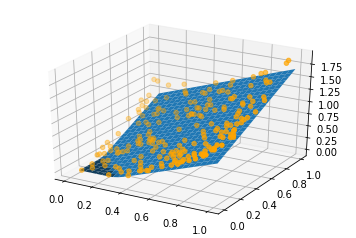

In [17]:
plt.close()
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, label = "train", c='orange')
ax.plot_surface(x1.reshape(1,nt), x2.reshape(nt,1), f_hat.reshape(nt,nt))
plt.savefig("3-2.png")

In [18]:
# classification
par, f_hat, err_trains, err_tests = my_NN(x_train, yc_train, x_test, yc_test, num_hidden=10, \
                                          learning_rate=1e-3, num_epoch=200, scale=1e-2, clf=True)

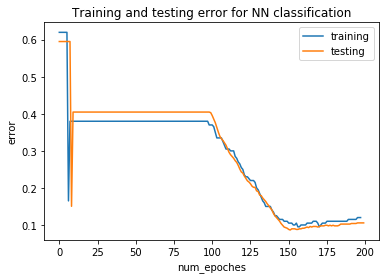

In [19]:
plt.close()
plt.title('Training and testing error for NN classification')
plt.xlabel('num_epoches')
plt.ylabel('error')
plt.plot(err_trains, label='training')
plt.plot(err_tests, label='testing')
plt.legend(loc='upper right')
plt.savefig("3-3.png")

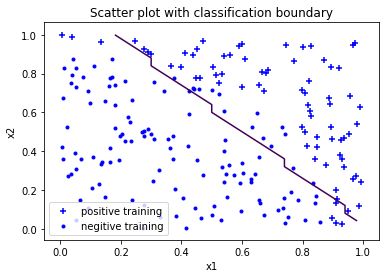

In [20]:
plt.title('Scatter plot with classification boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x_train[yc_train==1,0], x_train[yc_train==1,1], c='b', marker="+", label = 'positive training')
plt.scatter(x_train[yc_train==-1,0], x_train[yc_train==-1,1], c='b', marker=".", label = 'negitive training')
plt.legend()
plt.contour(x1, x2, f_hat.reshape(nt,nt), [0])
plt.savefig("3-4.png")